## ARIMA
- http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/
- https://rpubs.com/zkajdan/316135

In [15]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/2330.TW.csv')
#df

In [17]:
df = df[~ df['Close'].isna()]

Populating the interactive namespace from numpy and matplotlib


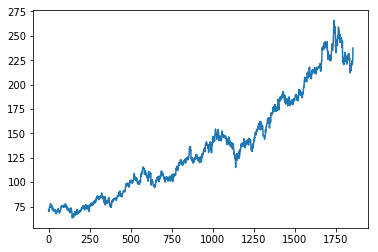

In [18]:
%pylab inline
df['Close'].plot(kind = 'line')

In [19]:
df.count()

Date         1851
Open         1851
High         1851
Low          1851
Close        1851
Adj Close    1851
Volume       1851
dtype: int64

In [20]:
trainset = df.iloc[0:1551,:]
testset  = df.iloc[1551: ,:]

In [21]:
trainset.shape

(1551, 7)

In [22]:
testset.shape

(300, 7)

In [23]:
trainset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1551,2017-04-25,190.5,192.0,189.5,192.0,179.272598,31932000.0
1552,2017-04-26,192.0,192.0,190.5,191.0,178.338898,29909000.0
1553,2017-04-27,192.0,193.0,190.5,193.0,180.206314,27940000.0
1554,2017-04-28,193.5,194.5,193.0,194.5,181.606888,34852000.0
1555,2017-05-02,198.5,199.0,195.5,196.5,183.474304,44119000.0


In [24]:
testset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0


In [25]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [37]:
X = trainset.Close.values
differenced = difference(X, 365)

In [39]:
differenced

array([10.200005, 12.100006, 14.399994, ..., 53.      , 54.5     ,
       57.5     ])

In [45]:
# fit model
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit(disp=0)

In [46]:
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

In [47]:
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 194.959280
Day 2: 192.553089
Day 3: 192.380521
Day 4: 192.642703
Day 5: 194.489287
Day 6: 199.143919
Day 7: 197.213715


In [49]:
testset[0 : 6]

,Date,Open,High,Low,Close,Adj Close,Volume
1556,2017-05-03,198.0,198.5,197.0,198.0,184.874878,25723000.0
1557,2017-05-04,198.5,199.0,197.0,198.0,184.874878,22088000.0
1558,2017-05-05,197.0,198.5,197.0,197.5,184.408020,17036000.0
1559,2017-05-08,199.0,202.5,199.0,202.5,189.076569,36538000.0
1560,2017-05-09,205.5,207.0,203.5,203.5,190.010284,48077000.0
1561,2017-05-10,204.0,206.0,204.0,205.5,191.877701,28312000.0


In [54]:
training_set = trainset[~ trainset['Close'].isna()].iloc[:, 4:5].values

In [55]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [56]:
import numpy as np
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [63]:
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [64]:
X_train.shape

(1491, 60, 1)

In [65]:
y_train.shape

(1491,)

## LSTM

In [66]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [67]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1491/1491 [==============================] - 7s 4ms/step - loss: 0.0378
Epoch 2/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0038
Epoch 3/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 4/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 5/100
1491/1491 [==============================] - 4s 2ms/step - loss: 0.0036
Epoch 6/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0036
Epoch 7/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 8/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 9/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0030
Epoch 10/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0029
Epoch 11/100
1491/1491 [==============================] - 4s 3ms/step - loss: 0.0031
Epoch 12/100
1491/1491 [==============================] - 4s 2ms/step - lo

1491/1491 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 98/100
1491/1491 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 99/100
1491/1491 [==============================] - 3s 2ms/step - loss: 0.0013
Epoch 100/100
1491/1491 [==============================] - 4s 2ms/step - loss: 9.9153e-04


In [71]:
real_stock_price = testset.iloc[:,4:5].values

In [72]:
dataset_total = pandas.concat((trainset['Close'], testset['Close']), axis = 0)
dataset_total.tail(30)

1827    227.0
1828    226.0
1829    229.0
1830    232.0
1831    226.5
1832    231.0
1833    225.0
1834    226.0
1835    226.5
1836    227.5
1837    218.0
1838    214.5
1839    213.0
1840    212.0
1841    216.5
1842    214.0
1843    214.5
1844    216.0
1845    214.5
1846    217.0
1847    221.5
1848    222.0
1849    220.0
1850    220.5
1851    224.5
1852    223.5
1853    221.5
1854    223.0
1855    224.5
1856    237.5
Name: Close, dtype: float64

In [74]:
inputs = dataset_total[len(dataset_total) - len(testset['Close']) - 60:].values

In [76]:
inputs = inputs.reshape(-1,1)

In [78]:
inputs = sc.transform(inputs)

In [83]:
len(inputs)

360

In [84]:
X_test = []
for i in range(60, 360):
    X_test.append(inputs[i-60:i, 0])

In [85]:
len(X_test)

300

In [87]:
X_test = np.array(X_test)

In [88]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [89]:
predicted_stock_price = regressor.predict(X_test)

In [91]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

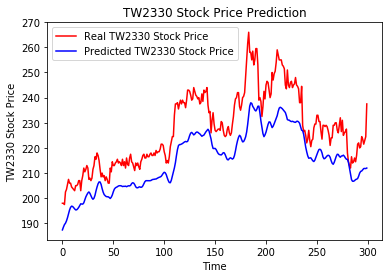

In [100]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()

In [96]:
predicted_stock_price2 = regressor.predict(X_train)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)
real_stock_price2 = training_set

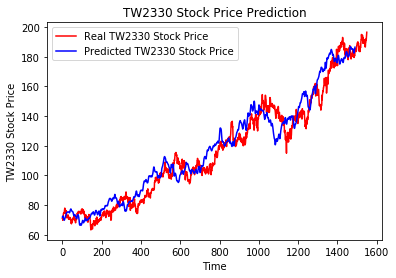

In [101]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price2, color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price2, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()